In [1]:
import random

import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# to play the audio files
from IPython.display import Audio
from pydub import AudioSegment
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
import openpyxl
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow


In [2]:
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [3]:
# Path for CREMA-D dataset
cremaD = "datasets/CremaD"

In [4]:
crema_directory_list = os.listdir(cremaD)
file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(cremaD + "/" + file)
    # storing file emotions
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.shape)


(7442, 2)


In [5]:
emotionCount = {}
for i in Crema_df.index:
    emotions = Crema_df["Emotions"][i]
    if emotions in emotionCount:
        emotionCount[emotions]+=1
    else:
        emotionCount[emotions]=1
emotionCount = dict(sorted(emotionCount.items(), key=lambda x: x[0]))
print(emotionCount)

{'angry': 1271, 'disgust': 1271, 'fear': 1271, 'happy': 1271, 'neutral': 1087, 'sad': 1271}


In [6]:
smallCount = min(emotionCount.values())
print(smallCount)
print(Crema_df.shape)

1087
(7442, 2)


In [7]:
counts = Crema_df['Emotions'].value_counts()

# find the minimum count
min_count = counts.min()

# create a list to store the balanced dataframes
balanced_dfs = []

# iterate over the emotions
for emotion in counts.index:
    # subset the data for the current emotion to have the minimum count
    balanced_df = Crema_df[Crema_df['Emotions'] == emotion].head(min_count)
    balanced_dfs.append(balanced_df)

# concatenate all the balanced dataframes into one final dataframe
final_df = pd.concat(balanced_dfs)
Crema_df = final_df
Crema_df


,Emotions,Path
0,angry,datasets/CremaD/1001_DFA_ANG_XX.wav
6,angry,datasets/CremaD/1001_IEO_ANG_HI.wav
7,angry,datasets/CremaD/1001_IEO_ANG_LO.wav
8,angry,datasets/CremaD/1001_IEO_ANG_MD.wav
22,angry,datasets/CremaD/1001_IOM_ANG_XX.wav
...,...,...
7416,neutral,datasets/CremaD/1091_MTI_NEU_XX.wav
7422,neutral,datasets/CremaD/1091_TAI_NEU_XX.wav
7428,neutral,datasets/CremaD/1091_TIE_NEU_XX.wav
7434,neutral,datasets/CremaD/1091_TSI_NEU_XX.wav


In [8]:
emotionCount = {}
for i in Crema_df.index:
    emotions = Crema_df["Emotions"][i]
    if emotions in emotionCount:
        emotionCount[emotions]+=1
    else:
        emotionCount[emotions]=1
emotionCount = dict(sorted(emotionCount.items(), key=lambda x: x[0]))
print(emotionCount)

{'angry': 1087, 'disgust': 1087, 'fear': 1087, 'happy': 1087, 'neutral': 1087, 'sad': 1087}


In [9]:
data_path = pd.concat([Crema_df], axis=0)
data_path.to_csv("data_path_C.csv", index=False)
data_path.head()
data_path.shape

(6522, 2)

In [10]:
emotionList = pd.read_csv("data_path_C.csv")
emotions = emotionList["Emotions"]
emotionCount = {}
for item in emotions:
    if item in emotionCount:
        emotionCount[item] += 1
    else:
        emotionCount[item] = 1
emotionCount=dict(sorted(emotionCount.items(), key=lambda x:x[0]))
print(emotionCount)

{'angry': 1087, 'disgust': 1087, 'fear': 1087, 'happy': 1087, 'neutral': 1087, 'sad': 1087}


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']

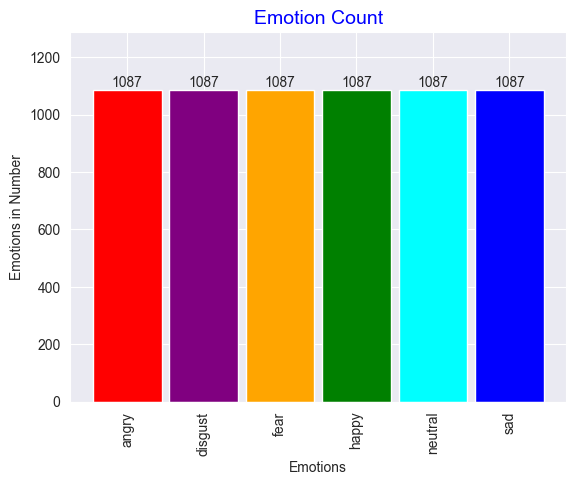

In [11]:
plt.bar(emotionCount.keys(), emotionCount.values(), width=0.9, align="center",
        color=["red","purple","orange","green","cyan","blue","yellow"])
plt.xlabel("Emotions")
plt.xticks(rotation=90)
plt.ylabel("Emotions in Number")
plt.title("Emotion Count", size=14, color="Blue")
plt.ylim([0, max(emotionCount.values()) + 200])
lst = []
for item in emotionCount:
    plt.text(item, emotionCount[item],
             emotionCount[item], ha="center", va="bottom")
sorted(emotionCount)

In [12]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()


def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    # librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()


In [13]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def volumeAdd(data):
    songData = AudioSegment.from_wav(data)
    print("sing", songData)
    songDataSamples = np.array(songData.get_array_of_samples())
    songHighVolumed = songDataSamples - 10000.0
    print(songHighVolumed)
    return songHighVolumed


datasets/CremaD/1001_IEO_ANG_HI.wav


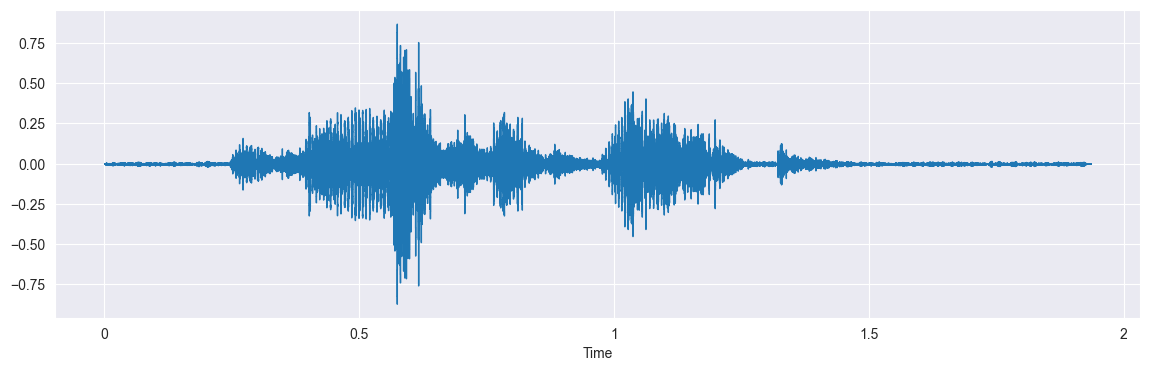

In [14]:
# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
print(path)
data, sample_rate = librosa.load(path)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)


In [15]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(
        S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(
        y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))  # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))  # stacking vertically

    return result


In [16]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    try:
        feature = get_features(path)
    except:
        print(path)
        print(emotion)
    for ele in feature:
        try:
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
        except:
            print(ele)

In [17]:
len(X), len(Y), data_path.Path.shape

(19566, 19566, (6522,))

In [18]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_excel('features_C.xlsx', index=False)
Features.head()


,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.083837,0.677546,0.700793,0.678332,0.680873,0.679725,0.584708,0.583747,0.652854,0.656525,...,6.626328e-08,6.204719e-08,5.876392e-08,5.609468e-08,5.394531e-08,5.227853e-08,5.099204e-08,5.010444e-08,4.954257e-08,angry
1,0.328071,0.774770,0.789207,0.811709,0.847721,0.817079,0.675867,0.664809,0.724533,0.717053,...,1.578891e-02,1.510249e-02,1.676691e-02,1.588154e-02,1.715301e-02,1.654694e-02,1.544226e-02,1.496393e-02,1.614063e-02,angry
2,0.091711,0.659439,0.620962,0.630467,0.676151,0.724627,0.611476,0.552105,0.626552,0.630631,...,6.375256e-08,5.868657e-08,5.494054e-08,5.213360e-08,4.897915e-08,4.116958e-08,2.717842e-08,1.526914e-08,1.062208e-08,angry
3,0.084026,0.736637,0.710209,0.659397,0.701769,0.645427,0.618778,0.562323,0.611433,0.635365,...,1.046150e-08,7.355192e-09,5.201333e-09,3.664950e-09,2.564611e-09,1.776725e-09,1.221200e-09,8.543607e-10,6.411403e-10,angry
4,0.313300,0.753089,0.821565,0.795793,0.829312,0.875383,0.782433,0.693458,0.657237,0.656436,...,1.942659e-02,1.867348e-02,1.820238e-02,1.956291e-02,1.911823e-02,1.893991e-02,1.900076e-02,1.697674e-02,1.868400e-02,angry


In [19]:
features_df = pd.read_excel("features_C.xlsx")

In [20]:
featuresofit = np.asarray(features_df.iloc[:,:-1].values)
X = featuresofit
labelofit = np.asarray(features_df['labels'])
Y = labelofit

In [21]:
emotionsfromFeatures = features_df['labels']
emotionCountfromFeatures = {}
for item in emotionsfromFeatures:
    if item in emotionCountfromFeatures:
        emotionCountfromFeatures[item] += 1
    else:
        emotionCountfromFeatures[item] = 1
print(emotionCountfromFeatures)

{'angry': 3261, 'disgust': 3261, 'fear': 3261, 'happy': 3261, 'sad': 3261, 'neutral': 3261}


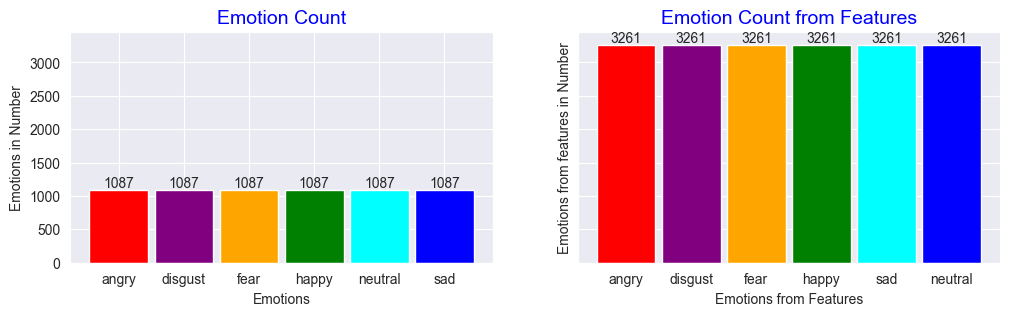

In [22]:
fig, (plt1,plt2) = plt.subplots(1,2,sharey=True, figsize=(12,3))
plt1.bar(emotionCount.keys(), emotionCount.values(), width=0.9, align="center",
        color=["red","purple","orange","green","cyan","blue","yellow"])
plt1.set_xlabel("Emotions")
plt1.set_ylabel("Emotions in Number")
plt1.set_title("Emotion Count", size=14, color="Blue")
plt1.set_ylim([0, max(emotionCount.values()) + 200])
# lst = []
for item in emotionCount:
    plt1.text(item, emotionCount[item],
             emotionCount[item], ha="center", va="bottom")

plt2.bar(emotionCountfromFeatures.keys(), emotionCountfromFeatures.values(), width=0.9, align="center",
        color=["red","purple","orange","green","cyan","blue","yellow"])
plt2.set_xlabel("Emotions from Features")
plt2.set_ylabel("Emotions from features in Number")
plt2.set_title("Emotion Count from Features", size=14, color="Blue")
plt2.set_ylim([0, max(emotionCountfromFeatures.values()) + 200])
# lst = []
for item in emotionCountfromFeatures:
    plt2.text(item, emotionCountfromFeatures[item],
             emotionCountfromFeatures[item], ha="center", va="bottom")
# plt2.subplots(nrows=1,ncols=2)

In [23]:
X = Features.iloc[:, :-1].values
Y = Features['labels'].values
y_labels = Y

In [24]:
# print(Y)
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, random_state=0, test_size=0.1, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# pd.DataFrame(Y)

((17609, 162), (17609,), (1957, 162), (1957,))

In [25]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17609, 162), (17609,), (1957, 162), (1957,))

In [26]:
kernelchoice = ["rbf"]
C_choice = [150,200,250,300,350]
import random

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

for i in C_choice:
    a=random.choice(kernelchoice)
    classifier = svm.SVC(kernel='linear', gamma="auto", C=i)
    classifier.fit(x_train, y_train)
    y_predict = classifier.predict(x_test)
    accuracyPercent = accuracy_score(y_test, y_predict) * 100
    print("Kernel:  "+ str(a) + "  ||  "+" C: " + str(i) +"  ||  Accuracy"+ "  :  " + str(accuracyPercent))

Kernel:  rbf  ||   C: 150  ||  Accuracy  :  44.864588656106285


In [ ]:
print(classification_report(y_test, y_predict))